# Princeton University FIN 580 Midterm 2024
## FIN 580: Quantitative Data Analysis in Finance
## Due: 11:59 pm on Mar 18, 2024


# Setup

In [1]:
# Setup codes
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans,SpectralClustering,DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

_DATA_DIR = './Data/'

----

# Macroeconomics Prediction

In this task, you're given access to a monthly macroeconomic dataset that covers a broad spectrum of indicators, providing a thorough insight into the U.S. economy. This dataset is regularly updated on a monthly basis. For your convenience, we have prepared a cleaned version of this dataset for analysis. The pre-processing involves de-trend and de-seasonality that you no longer need worry about. Your objective is to create a model designed to forecast Industrial Production (IP) growth. In the dataset provided, 'Y' represents the IP growth rate. Your primary focus should be on developing and suggesting a model that can accurately predict future IP growth rate using the available data.

The dataset features columns that are coded for anonymity. To understand their actual macroeconomic interpretations, please consult the accompanying excel file named `macrodata_appendix.csv`.

## Part I. Data preparation

Run the following cells to load the macroeconomic data. You don't need to modify any codes here.

In [2]:
# load data
Macro1 = pd.read_csv(_DATA_DIR+'FredMD.csv')
Macro1 = Macro1.drop(Macro1.columns[0], axis=1)
X = Macro1.iloc[:, :-1]
y = Macro1.iloc[:, -1]
X['LagIP'] = y.shift(1)
X = X.iloc[1:]
y = y.iloc[1:]
X.head(5)

,['RPI'],['W875RX1'],['DPCERA3M086SBEA'],['CMRMTSPLx'],['RETAILx'],['INDPRO'],['IPFPNSS'],['IPFINAL'],['IPCONGD'],['IPDCONGD'],...,['DDURRG3M086SBEA'],['DNDGRG3M086SBEA'],['DSERRG3M086SBEA'],['CES0600000008'],['CES2000000008'],['CES3000000008'],['DTCOLNVHFNM'],['DTCTHFNM'],['INVEST'],LagIP
1,0.001147,0.000906,0.004361,0.014403,0.003696,-0.008939,-0.005685,-0.003435,-0.011457,-0.013855,...,0.003750,0.001683,0.000858,-0.004555,0.003853,-0.004750,0.008268,0.005388,-0.018942,-0.008939
2,0.001877,0.000905,0.014089,-0.028040,-0.001102,-0.009019,-0.003427,-0.001150,0.001153,-0.019965,...,-0.004537,0.001791,-0.001146,-0.000020,0.030131,-0.004684,0.003472,0.000951,0.003490,-0.009019
3,0.003465,0.003612,0.015302,0.009853,0.025903,-0.007959,0.002290,0.001150,0.006880,-0.001189,...,0.004115,0.004424,0.001523,-0.008949,-0.068074,0.000000,0.008678,0.005452,0.024136,-0.007959
4,0.002405,0.002427,-0.020351,-0.031518,-0.015047,-0.001143,0.005688,0.006862,0.005699,0.009455,...,-0.001304,-0.006700,0.000565,0.008949,0.041620,0.000000,-0.004827,-0.002067,0.003798,-0.001143
5,0.000764,-0.000235,-0.000250,0.008553,-0.001364,-0.012653,-0.011412,-0.011468,-0.006841,-0.010641,...,-0.002611,0.000215,-0.000764,-0.004474,-0.011429,0.000000,0.005126,0.007420,-0.009981,-0.012653


## Part II. Exploratory Data Analysis (EDA) 

Perform EDA to do some preliminary analysis. Answer the following questions.

+ How does the trend of IP growth look like? Run the following code.

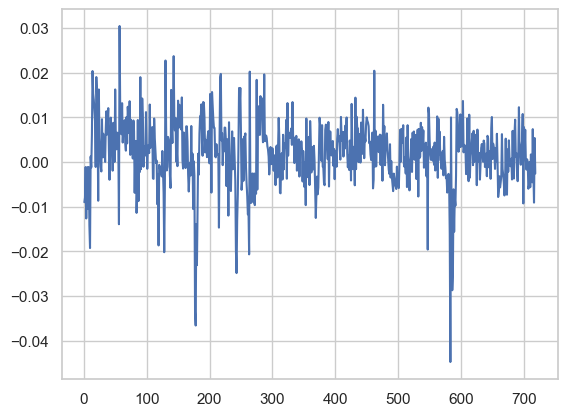

In [3]:
plt.plot(y)
plt.show()

In [10]:
# compute the statistics to detect the heavy-tailness of each column of Macro1, then show the min and max values and the 5% 95% quantiles
# for col in X.columns:
#     print(col)
#     print(X[col].describe(percentiles=[0.05, 0.95]))
#     print('\n')
# construct a new dataframe to show the min and max values and the 5% 95% quantiles
df = pd.DataFrame()
df['min'] = Macro1.min()
df['max'] = Macro1.max()
df['5%'] = Macro1.quantile(0.01)
df['95%'] = Macro1.quantile(0.99)
df['kurtosis'] = Macro1.kurtosis()
df.head(50)

,min,max,5%,95%,kurtosis
['RPI'],-0.051171,0.041527,-0.012379,0.018339,24.405086
['W875RX1'],-0.061197,0.040169,-0.011004,0.012876,35.022944
['DPCERA3M086SBEA'],-0.025422,0.025443,-0.012456,0.016331,3.124344
['CMRMTSPLx'],-0.036168,0.045894,-0.028698,0.028262,1.257290
['RETAILx'],-0.066719,0.064710,-0.026181,0.035117,4.816355
['INDPRO'],-0.044790,0.030432,-0.020604,0.019683,4.654097
['IPFPNSS'],-0.033067,0.029305,-0.019860,0.019256,2.376109
['IPFINAL'],-0.034462,0.031929,-0.021703,0.020571,2.056848
['IPCONGD'],-0.033797,0.042181,-0.021455,0.024712,1.872631
['IPDCONGD'],-0.120198,0.128118,-0.055946,0.059226,6.282607


+ Draw a plot to compare different variables' correlation with IP growth rate. Which variables do you think are most useful? (5 Points)

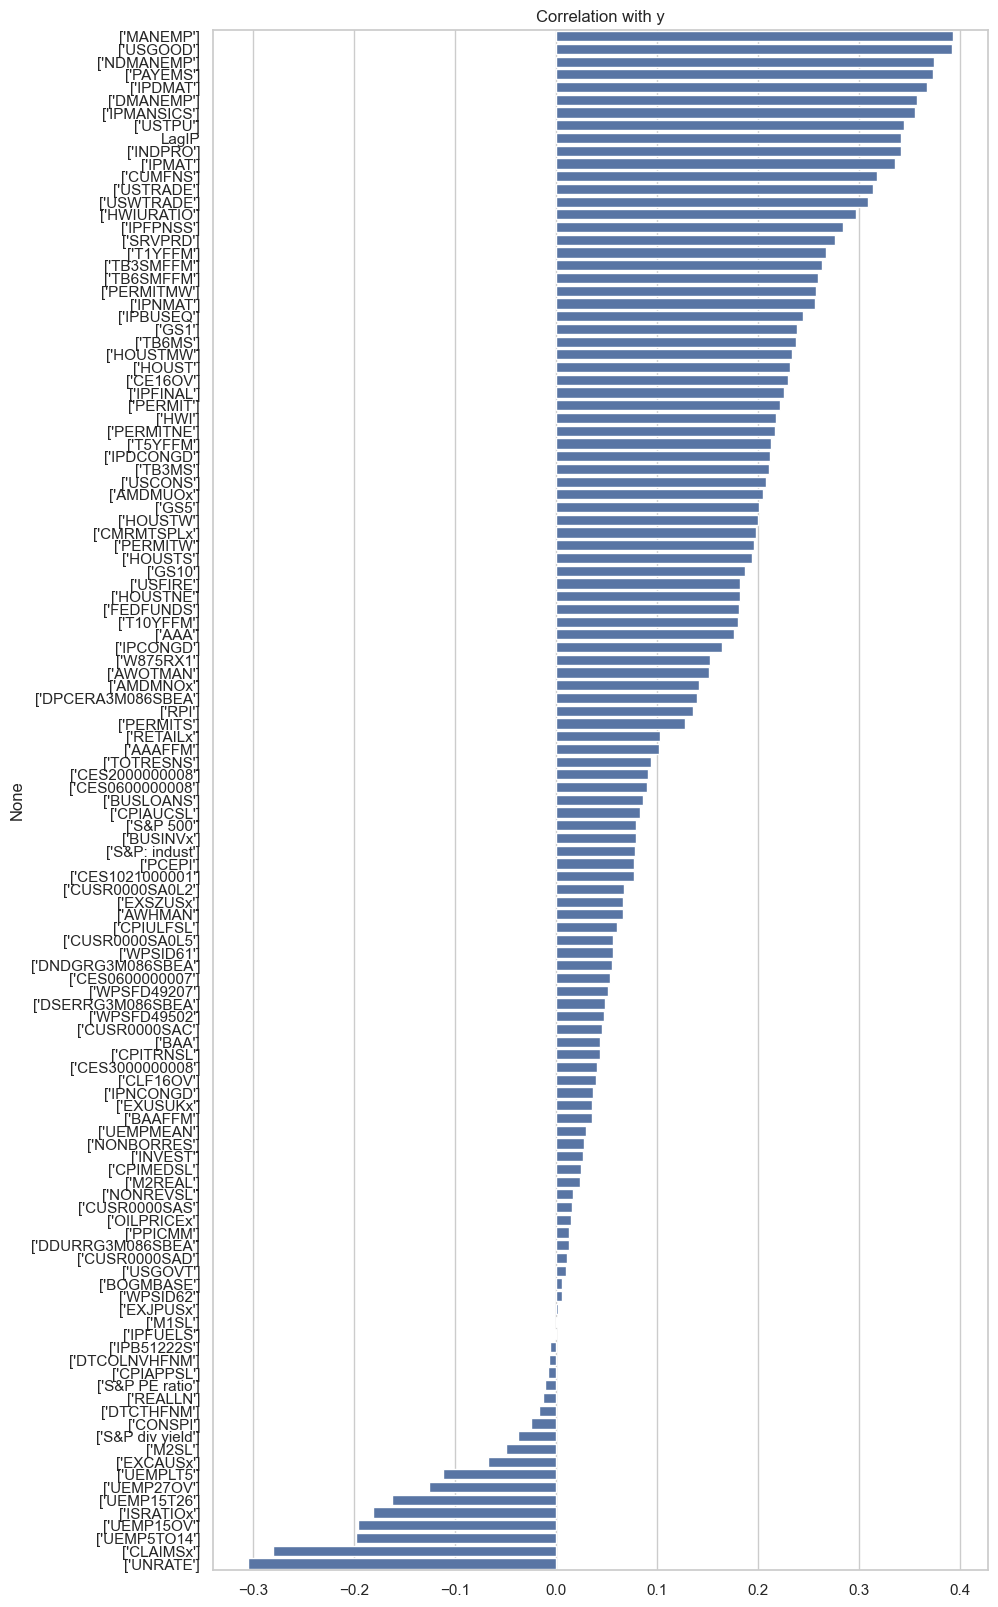

In [5]:
# Draw a plot to compare different variables' correlation with y.
corr = X.corrwith(y)
corr = corr.sort_values(ascending=False)
plt.figure(figsize=(10, 20))
sns.barplot(x=corr.values, y=corr.index)
plt.title('Correlation with y')
plt.show()


## Part III. Model Selection & Parameter Tuning

In this section, you are tasked with fitting four distinct models: Lasso Regression, Ridge Regression, Random Forest Regression, and Gradient Boosted Regression Trees. The benchmark model is a times series model: AR(1). Each model should be implemented using two different data partitioning strategies: the expanding window scheme and the rolling window scheme. Your goal is to evaluate and compare the out-of-sample prediction performance of these models.

The expanding window scheme is a training and testing approach where the training dataset starts with a small subset of the data and incrementally incorporates more data points over time. This results in the training dataset growing to encompass a larger portion of the historical data, while the test set advances along the time axis, ensuring that the models are trained on increasingly comprehensive historical data.

In contrast, the rolling window scheme involves advancing both the training and test sets forward in time by a fixed interval. This strategy ensures that the models are consistently trained and tested on consecutive datasets that are regularly updated with new data, maintaining a constant window size for both training and testing periods.

### Step 1: Rolling Window & Expanding Window 

+ Finish the following functions for building rolling window and expanding window iterators. The "step" parameter dictates the duration, in months, that each model remains valid, with a default value of 12 months to ensure that models derived from each rolling or expanding window remain effective for one year. (5 points)

In [18]:
# generate rolling window iterator
def rolling_window_iterator(data, start_year = 1975, step = 12):
    tscv_rolling = []
    train_size = (start_year-1960)*12-2
    for i in range(0,len(data) - train_size-step+1,step):
        ##############################################################################
        ### Define train and validation indices
        ##############################################################################
        train_index = data[i:(i+train_size)].index.values.astype(int)
        ##############################################################################
        tscv_rolling.append(train_index)
    return tscv_rolling

# generate expanding window iterator
def expanding_window_iterator(data, start_year = 1975, step = 12):
    tscv_expanding = []
    train_size = (start_year-1960)*12-2
    for i in range(0,len(data) - train_size - step+1,step):
        ##############################################################################
        ### TODO: Define train and validation indices
        ##############################################################################
        train_index = data[0:(i+train_size)].index.values.astype(int)
        ##############################################################################
        # END OF YOUR CODE
        tscv_expanding.append(train_index)
    return tscv_expanding

## Step 2: Set Up LASSO, Ridge, RF, & GBRT

In [25]:
def deviance(y, pred, family):
    if family == 'gaussian':
        return np.sum((y - pred)**2)
    if family == 'binomial':
        return -2 * np.sum(y * np.log(pred) + (1-y) * np.log(1-pred))

+ Finish the code for Lasso, Ridge, RF, and GBRT. Ensure your codes run smoothly with the functions provided below. (40 points)

In [ ]:
def lasso_tuning(X_train, y_train, X_test, y_test, alphas):
    """ Get series of dev0 and dev for given training and validation data and alphas
    X_train: np.array of training covariates
    y_train: np.array of training target
    X_test: np.array of testing covariates
    y_test: np.array of testing target
    alphas: array of penalty strength
    """

    ##############################################################################
    ### TODO: Construct Lasso
    ##############################################################################
    
    Xscaler = 
    y_train = 
    yscaler = 
    
    X_train_scaled = 
    y_train_scaled = 
    X_test_scaled = 
    
    lasso = LassoCV(alphas=alphas, cv=3,random_state=0)
    lasso.fit(X_train_scaled, y_train_scaled) 
    best_alpha = lasso.alpha_
    
    y_pred_scaled = 
    y_pred = 
    dev0 = 
    dev = 
    

    ##############################################################################
        # END OF YOUR CODE
    return dev0, dev, best_alpha

In [ ]:
def ridge_tuning(X_train, y_train, X_test, y_test, alphas):
    """ Get series of dev0 and dev for given training and validation data and alphas
    X_train: np.array of training covariates
    y_train: np.array of training target
    X_test: np.array of testing covariates
    y_test: np.array of testing target
    alphas: array of penalty strength
    """
    ##############################################################################
    ### TODO: Construct Ridge
    ##############################################################################
    
    

    ##############################################################################
        # END OF YOUR CODE
    return dev0, dev, best_alpha

In [26]:
def rf_tuning(X_train, y_train, X_test, y_test, param_grid):
 
    """ Get series of dev0 and dev for given training and testing data and tuning parameters
    X_train: np.array of training covariates
    y_train: np.array of training target
    X_test: np.array of testing covariates
    y_test: np.array of testing target
    param_grid: tuning parameters
    """

    ##############################################################################
    ### TODO: Construct RF
    ##############################################################################
    
    rf = RandomForestRegressor(n_estimators=500, random_state = 0)
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search_rf.fit(X_train, y_train.ravel())  
    best_params = grid_search_rf.best_params_
    best_rf = grid_search_rf.best_estimator_

    y_pred =  best_rf.predict(X_test)
    dev0 = np.sum((y_test - np.mean(y_test))**2)
    dev = deviance(y_test, y_pred, family="gaussian")

     ##############################################################################
        # END OF YOUR CODE
    
    return dev0, dev, best_params

In [ ]:
def gbrt_tuning(X_train, y_train, X_test, y_test, param_grid):

    """ Get series of dev0 and dev for given training and testing data and tuning parameters
    X_train: np.array of training covariates
    y_train: np.array of training target
    X_test: np.array of testing covariates
    y_test: np.array of testing target
    param_grid: tuning parameters
    """
    ##############################################################################
    ### TODO: Construct GBRT
    ############################################################################### 

    

     ##############################################################################
        # END OF YOUR CODE
    
    return dev0, dev, best_params

### Step 3: Set Up Training and Prediction Procedures

You don't need modify any codes here.

In [ ]:
def solver1(X, y, mylist, method, params):
    
    """Get OOS mse and r2 of different windows and best alphas
    X: np.array of covariates
    y: np.array of target
    mylist: expanding list or rolling list
    method: lasso or ridge
    params: tuning parameters 
    """
    
    table_mse = pd.DataFrame(columns = range(len(mylist)))
    table_r2 = pd.DataFrame(columns = range(len(mylist)))
    table_alpha = pd.DataFrame(columns = range(len(mylist)))

    for k in tqdm(range(len(mylist))):
        train_idx = mylist[k]
        X_train = X.iloc[train_idx,:]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[(train_idx[-1]):(train_idx[-1]+12), :]
        y_test = y.iloc[(train_idx[-1]):(train_idx[-1]+12)]
        
        if method == 'lasso':
            dev0_ser, dev_ser, alpha = lasso_tuning(X_train, y_train, X_test, y_test, params)
            table_mse.loc['Lasso_mse',k] = dev_ser/len(y_test)
            table_r2.loc['Lasso_r2',k] = 1 - dev_ser/dev0_ser
        elif method == 'ridge':
            dev0_ser, dev_ser, alpha = ridge_tuning(X_train, y_train, X_test, y_test, params)
            table_mse.loc['Ridge_mse',k] = dev_ser/len(y_test)
            table_r2.loc['Ridge_r2',k] = 1 - dev_ser/dev0_ser
        else:
            raise ValueError(f"Unsupported method: {method}")

        table_alpha.loc['Alpha_best',k] = alpha
    
    
    return table_mse,table_r2,table_alpha
    

In [13]:
def solver2(X, y, mylist, method, params):
    
    """Get OOS mse and r2 of different windows.
    X: np.array of covariates
    y: np.array of target
    mylist: expanding list or rolling list
    method: rf or gbrt
    params: tuning parameters 
    """
    
    table_mse = pd.DataFrame(columns = range(len(mylist)))
    table_r2 = pd.DataFrame(columns = range(len(mylist)))
    all_best_params = []

    for k in tqdm(range(len(mylist))):
        train_idx = mylist[k]
        X_train = X.iloc[train_idx,:]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[(train_idx[-1]):(train_idx[-1]+12), :]
        y_test = y.iloc[(train_idx[-1]):(train_idx[-1]+12)]
        
        if method == 'rf':
            dev0_ser, dev_ser, best_params = rf_tuning(X_train, y_train, X_test, y_test, params)
            table_mse.loc['RF_mse',k] = dev_ser/len(y_test)
            table_r2.loc['RF_r2',k] = 1 - dev_ser/dev0_ser
        elif method == 'gbrt':
            dev0_ser, dev_ser, best_params = gbrt_tuning(X_train, y_train, X_test, y_test, params)
            table_mse.loc['GBRT_mse',k] = dev_ser/len(y_test)
            table_r2.loc['GBRT_r2',k] = 1 - dev_ser/dev0_ser
        else:
            raise ValueError(f"Unsupported method: {method}")
        
        all_best_params.append(best_params)
   
    return table_mse,table_r2,all_best_params

## Step 4: Training 

## Benchmark: AR(1)

Finish the codes below for regressing the response variable `y` on its 1-time lag `y_{t-1}`. Return the mean squared error (MSE) of your baseline model. (10 points)

In [16]:
def ARtrain(y, mylist):
        
    """Get OOS mse and r2 of different windows.
    y: np.array of target
    mylist: expanding list or rolling list
    """
    table_mse = pd.DataFrame(columns = range(len(mylist)))
    
    for k in tqdm(range(len(mylist))):
        train_idx = mylist[k]
        yinput_train = y[train_idx][:-1].values.reshape(-1,1)
        yaim_train = y[train_idx][1:].values.reshape(-1,1)
        yinput_test = y[(train_idx[-1]-1):(train_idx[-1]+11)].values.reshape(-1,1)
        yaim_test = y[(train_idx[-1]):(train_idx[-1]+12)].values.reshape(-1,1)
        model = LinearRegression().fit(yinput_train, yaim_train)

    ##############################################################################
    ### TODO: Finish AR Prediction
    ############################################################################### 
       
        y_pred_test = model.predict(yinput_test)
        # yaim_test =         
        mse_test = mean_squared_error(yaim_test, y_pred_test)
     
    ##############################################################################
        # END OF YOUR CODE  
        table_mse.loc['MSE', k] = mse_test

    return table_mse
    

### AR Training with Expanding Window

In [19]:
# generate expanding window iterator
expanding_list = expanding_window_iterator(y)
# Run AR training procedure
mse_ar_expanding = ARtrain(y, expanding_list)

 44%|████▍     | 20/45 [00:00<00:00, 100.71it/s]

100%|██████████| 45/45 [00:00<00:00, 84.57it/s] 


In [20]:
mse_ar_expanding

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
MSE,0.000059,0.000024,0.000043,0.000067,0.000055,0.000099,0.000045,0.000143,0.000082,0.000027,...,0.000027,0.00003,0.000015,0.00001,0.000018,0.000029,0.000025,0.000026,0.000037,0.000037


### AR Training with Rolling Window

In [21]:
# generate expanding window iterator
rolling_list = rolling_window_iterator(y)
# Run AR training procedure
mse_ar_rolling = ARtrain(y, rolling_list)

100%|██████████| 45/45 [00:00<00:00, 107.63it/s]


In [22]:
mse_ar_rolling

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
MSE,0.000059,0.000023,0.000042,0.000067,0.000055,0.000093,0.000041,0.000144,0.00009,0.000028,...,0.00003,0.000029,0.000014,0.000009,0.000018,0.000024,0.000023,0.000025,0.000034,0.000031


In [23]:
mse_ar_rolling.mean(axis=1)

MSE    0.000044
dtype: object

## Prediction based on Lasso

### Lasso Training with Expanding Window

+ Select Tuning Parameter Range for Lasso (10 Points)

In [ ]:
# generate expanding window iterator
expanding_list = expanding_window_iterator(y)

##############################################################################
    ### TODO: Select a grid of alphas
    ##############################################################################
    
alphas =

 ##############################################################################
        # END OF YOUR CODE

expanding_lasso_table, expanding_l_r2_table,alpha_best_Lasso_expanding = solver1(X, y, expanding_list, method = 'lasso', params=alphas)

# Report the best alphas. Based on this, think if your tuning parameter range is reasonable.

alpha_best_Lasso_expanding


In [ ]:
expanding_lasso_table.mean(axis=1)

### Lasso Training with Rolling Window

+ Select Tuning Parameter Range for Lasso (10 Points)

In [ ]:
# generate rolling window iterator
rolling_list = rolling_window_iterator(y)

##############################################################################
    ### TODO: Select a grid of alphas
    ##############################################################################
    
alphas =

 ##############################################################################
        # END OF YOUR CODE

rolling_lasso_table, rolling_l_r2_table,alpha_best_Lasso_rolling = solver1(X, y, rolling_list, method = 'lasso', params=alphas)


# Report the best alphas. Based on this, think if your tuning parameter range is reasonable.

alpha_best_Lasso_rolling


In [ ]:
rolling_lasso_table.mean(axis=1)

## Prediction based on Ridge

### Ridge Training with Expanding Window

+ Select Tuning Parameter Range for Ridge (10 Points)

In [ ]:
# generate expanding window iterator
expanding_list = expanding_window_iterator(y)


##############################################################################
    ### TODO: Select a grid of alphas
    ##############################################################################
    
alphas = 

 ##############################################################################
        # END OF YOUR CODE

expanding_ridge_table, expanding_r_r2_table, alpha_best_Ridge_expanding = solver1(X, y, expanding_list, method = 'ridge', params=alphas)


# Report the best alphas. Based on this, think if your tuning parameter range is reasonable.

alpha_best_Ridge_expanding




In [ ]:
expanding_ridge_table.mean(axis=1)

### Ridge Training with Rolling Window

+ Select Tuning Parameter Range for Ridge (10 Points)

In [ ]:
# generate rolling window iterator
rolling_list = rolling_window_iterator(y)


##############################################################################
    ### TODO: Select a grid of alphas
    ##############################################################################
    
alphas = 

 ##############################################################################
        # END OF YOUR CODE

rolling_ridge_table, rolling_r_r2_table,alpha_best_Ridge_rolling = solver1(X, y, rolling_list, method = 'ridge', params=alphas)


# Report the best alphas. Based on this, think if your tuning parameter range is reasonable.

alpha_best_Ridge_rolling 



In [ ]:
rolling_ridge_table.mean(axis=1)

## Random Forest

### RF Training with Expanding Window

+ Select Tuning Parameter Range for RF (10 Points)

In [27]:
# generate expanding window iterator
expanding_list = expanding_window_iterator(y)

##############################################################################
    ### TODO: Select a grid of parameters
    ##############################################################################

grid_rf = {
    'max_depth': [3,5],  
    'max_features': [10,120]
}

 ##############################################################################
        # END OF YOUR CODE


expanding_rf_mse_table,expanding_rf_r2_table,best_params_rf_expanding = solver2(X, y, expanding_list, method = 'rf', params=grid_rf)

  0%|          | 0/45 [00:00<?, ?it/s]

  2%|▏         | 1/45 [00:27<20:01, 27.30s/it]


KeyboardInterrupt: 

In [ ]:
# Report the best tuning parameters. Based on this, think if your tuning parameter range is reasonable.

best_params_rf_expanding

### RF Training with Rolling Window

+ Select Tuning Parameter Range for RF (10 Points)

In [28]:
# generate rolling window iterator
rolling_list = rolling_window_iterator(y)

##############################################################################
    ### TODO: Select a grid of parameters
    ##############################################################################

grid_rf = {
    'max_depth': [3,5],  
    'max_features': [10,50]
}

 ##############################################################################
        # END OF YOUR CODE


rolling_rf_mse_table,rolling_rf_r2_table,best_params_rf_rolling = solver2(X, y, rolling_list, method = 'rf', params=grid_rf)

  4%|▍         | 2/45 [00:28<10:19, 14.42s/it]


KeyboardInterrupt: 

In [ ]:
## Report the best tuning parameters. Based on this, think if your tuning parameter range is reasonable.

best_params_rf_rolling

## GBRT

### GBRT Training with Expanding Window

+ Select Tuning Parameter Range for GBRT (10 Points)

In [ ]:
# generate expanding window iterator
expanding_list = expanding_window_iterator(y)

##############################################################################
    ### TODO: Select a grid of parameters
##############################################################################

grid_gbrt = {
    'max_depth': [], 
    'n_estimators': [],
    'learning_rate': []
}

 ##############################################################################
        # END OF YOUR CODE

expanding_gbrt_mse_table,expanding_gbrt_r2_table,best_params_gbrt_expanding = solver2(X, y, expanding_list, method = 'gbrt', params=grid_gbrt)

In [ ]:
# Report the best tuning parameters. Based on this, think if your tuning parameter range is reasonable.

best_params_gbrt_expanding

### GBRT Training with Rolling Winwdow

+ Select Tuning Parameter Range for GBRT (10 Points)

In [ ]:
# generate rolling window iterator
rolling_list = rolling_window_iterator(y)

##############################################################################
    ### TODO: Select a grid of parameters
    ##############################################################################

grid_gbrt = {
    'max_depth': [], 
    'n_estimators': [],
    'learning_rate': []
}

 ##############################################################################
        # END OF YOUR CODE


rolling_gbrt_mse_table,rolling_gbrt_r2_table,best_params_gbrt_rolling = solver2(X, y, rolling_list, method = 'gbrt', params=grid_gbrt)

In [ ]:
rolling_gbrt_r2_table.mean(axis=1)

In [ ]:
# Report the best tuning parameters. Based on this, think if your tuning parameter range is reasonable.

best_params_gbrt_rolling

## Step 5: Model Comparison

+ Using the following code to compare your trained models with baseline model regarding MSE and R2. You don't need modify any code here. 

In [ ]:
l_mse_expanding = expanding_lasso_table.squeeze().tolist()
r_mse_expanding = expanding_ridge_table.squeeze().tolist()
rf_mse_expanding = expanding_rf_mse_table.squeeze().tolist()
gbrt_mse_expanding = expanding_gbrt_mse_table.squeeze().tolist()

OOS_MSE_expanding = pd.DataFrame({'Lasso':l_mse_expanding,'Ridge': r_mse_expanding,'RF': rf_mse_expanding, 'GBRT': gbrt_mse_expanding})

In [ ]:
l_r2_expanding = 1 - expanding_lasso_table.div(mse_ar_expanding.values)
l_r2_expanding = l_r2_expanding.squeeze().tolist()

r_r2_expanding = 1 - expanding_ridge_table.div(mse_ar_expanding.values)
r_r2_expanding = r_r2_expanding.squeeze().tolist()

rf_r2_expanding = 1 - expanding_rf_mse_table.div(mse_ar_expanding.values)
rf_r2_expanding = rf_r2_expanding.squeeze().tolist()

gbrt_r2_expanding = 1 - expanding_gbrt_mse_table.div(mse_ar_expanding.values)
gbrt_r2_expanding = gbrt_r2_expanding.squeeze().tolist()

OOS_R2_expanding = pd.DataFrame({'Lasso':l_r2_expanding, 'Ridge':r_r2_expanding, 'RF': rf_r2_expanding, 'GBRT': gbrt_r2_expanding})

In [ ]:
l_mse_rolling = rolling_lasso_table.squeeze().tolist()
r_mse_rolling = rolling_ridge_table.squeeze().tolist()
rf_mse_rolling = rolling_rf_mse_table.squeeze().tolist()
gbrt_mse_rolling = rolling_gbrt_mse_table.squeeze().tolist()

OOS_MSE_rolling = pd.DataFrame({'Lasso':l_mse_rolling,'Ridge': r_mse_rolling,'RF': rf_mse_rolling, 'GBRT': gbrt_mse_rolling})

In [ ]:
l_r2_rolling = 1 - rolling_lasso_table.div(mse_ar_rolling.values)
l_r2_rolling = l_r2_rolling.squeeze().tolist()

r_r2_rolling = 1 - rolling_ridge_table.div(mse_ar_rolling.values)
r_r2_rolling = r_r2_rolling.squeeze().tolist()

rf_r2_rolling = 1 - rolling_rf_mse_table.div(mse_ar_rolling.values)
rf_r2_rolling = rf_r2_rolling.squeeze().tolist()

gbrt_r2_rolling = 1 - rolling_gbrt_mse_table.div(mse_ar_rolling.values)
gbrt_r2_rolling = gbrt_r2_rolling.squeeze().tolist()

OOS_R2_rolling = pd.DataFrame({'Lasso':l_r2_rolling, 'Ridge':r_r2_rolling, 'RF': rf_r2_rolling, 'GBRT': gbrt_r2_rolling})

In [ ]:
plt.figure(figsize = (16,8))

plt.subplot(1, 2, 1)

sns.boxplot(data=OOS_R2_expanding )
plt.xlabel('model')
plt.ylabel('R2')
plt.title('OOS R2 expanding')

plt.subplot(1, 2, 2)

sns.boxplot(data=OOS_MSE_expanding )
plt.xlabel('model')
plt.ylabel('MSE')
plt.title('OOS MSE expanding')


In [ ]:
plt.figure(figsize = (16,8))

plt.subplot(1, 2, 1)

sns.boxplot(data=OOS_R2_rolling )
plt.xlabel('model')
plt.ylabel('R2')
plt.title('OOS R2 rolling')

plt.subplot(1, 2, 2)

sns.boxplot(data=OOS_MSE_rolling )
plt.xlabel('model')
plt.ylabel('MSE')
plt.title('OOS MSE rolling')


+ Which model is best? Does your conclusion depend on rolling or expanding window design? (10 points)

+ Is there any reason that supports your findings (10 points)?